### 다양한 모델을 결합한 앙상블
- 앙상블
- 다수결 투표 앙상블(voting)
- 배깅(Bagging)
- 에이다부스트(AdaBoost)
- 그레이던스 부스팅 & XGBoost
- 모델성능 평가 및 비교

#### 단일모델의 한계
    - 과대적합(overfitting) : 학습데이터에 너무 맞춰져 있어서 새로우 데이터에 대하 성능 저하
    - 과소적합(underfitting) : 모델이 너무 단순해서 제대로 학습이 안됨
    - 높은 분산(high variance) : 학습 데이터가 조금만 바뀌어도 모델이 크게 달라지는 현상
    - 높은 편향(high bias) : 모델이 진짜 패턴을 포착하지 못함
    
 - 앙상블(집단지성)
    - 배깅 : 같은 알고리즘, 다른 데이터셋(부트스트랩) / 랜덤포레스트 -> 분산감소
    - 부스팅 : 순차적으로 약한 학습기를 강화 / AdaBoost, XGBoost -> 편향을 감소
    - 스태킹 : 서로 다른 알고리즘을 메타 모델로 학습 / 일반화 성능을 증가시킴


#### voting
   - Hard voing : 다수결 투표
            A : 고양이  
            B : 강아지  
            C : 고양이  

   - Soft voting : 가중치 투표-> 확률을 보고 결정. 하드보팅보다 성능이 좋음
            A : (0.9, 0.1) 
            B : (0.4, 0.6)  
            C : (0.6, 0.2) 

#### bagging (bagging - bootstrap aggregation)
   - bootstrap : 원본 데이터 1000이면 중복을 허용해 1000개를 뽑아 훈련세트 1개를 만들어 학습
   - aggregation : 순차적으로 학습을 하고 난 후 여러개의 모델들을 voting해서 최종결론을 낸다 
      - 대표모델은 랜덤포레스트
   - 효과 : 과적합을 방지. 즉 모델의 분산을 줄여줌

#### Boosting
   - 모델들이 순서대로 학습, 앞 모델의 실수를 뒷 모델이 보완  
   - 모델1이 전체 데이터를 학습하고 예측  
   - 모델1이 틀린 문제를 찾는다  
   - 모델1이 틀린 문제에 더 높은 가중치(중요도)를 부여  
   - 모델2가 틀리기 쉬운 문제들을 좀 더 학습  
   - 모델2가 틀린 문제를 찾는다  
   - 모델3는 모델1과 모델2가 틀린 문제들에 집중 -> 가중치 부여  
   - 반복  
    => 결론  
     - 예측을 합친다 성적이 더 좋은 모델의 가중치를 부여해서 최종 결론
     - 편향을 줄여준다

#### 스태킹
   - 1 base model : 여러개의 모델을 훈련  
   - 2 base model  
     - 1단계 모델들이 예측한 값들을 모음  
     - 예측한 값을 훈련데이터(특성)로 사용  
   - 결론 -> 새로운 데이터를 최종모델(meta_model)을 이용해서 결론을 도출

---

#### 보팅

In [37]:
# 데이터 생성
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

X,y = make_classification(n_samples=500, n_features=2,random_state=42,n_redundant=0,n_clusters_per_class=1)
np.unique(y,return_counts=True), X.shape
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 개별모델 생성 학습
lr = LogisticRegression(random_state=42)
svm = SVC(random_state=42,probability=True)
knn = KNeighborsClassifier()
lr.fit(x_train,y_train) ; svm.fit(x_train,y_train) ; knn.fit(x_train,y_train)

# 보팅 앙상블
voting_hard = VotingClassifier(estimators=[('lr',lr),('svm',svm),('knn',knn)],voting='hard')
voting_soft = VotingClassifier(estimators=[('lr',lr),('svm',svm),('knn',knn)],voting='soft')

voting_hard.fit(x_train, y_train)
voting_soft.fit(x_train, y_train)

models  = [
    ('lr',lr),
    ('svm',svm),
    ('knn',knn),
    ('voting_hard',voting_hard),
    ('voting_soft',voting_soft)
           ]
for label ,model in models:
  print(f'{label} : { model.score(x_test, y_test)}')
     



lr : 0.88
svm : 0.93
knn : 0.97
voting_hard : 0.94
voting_soft : 0.96


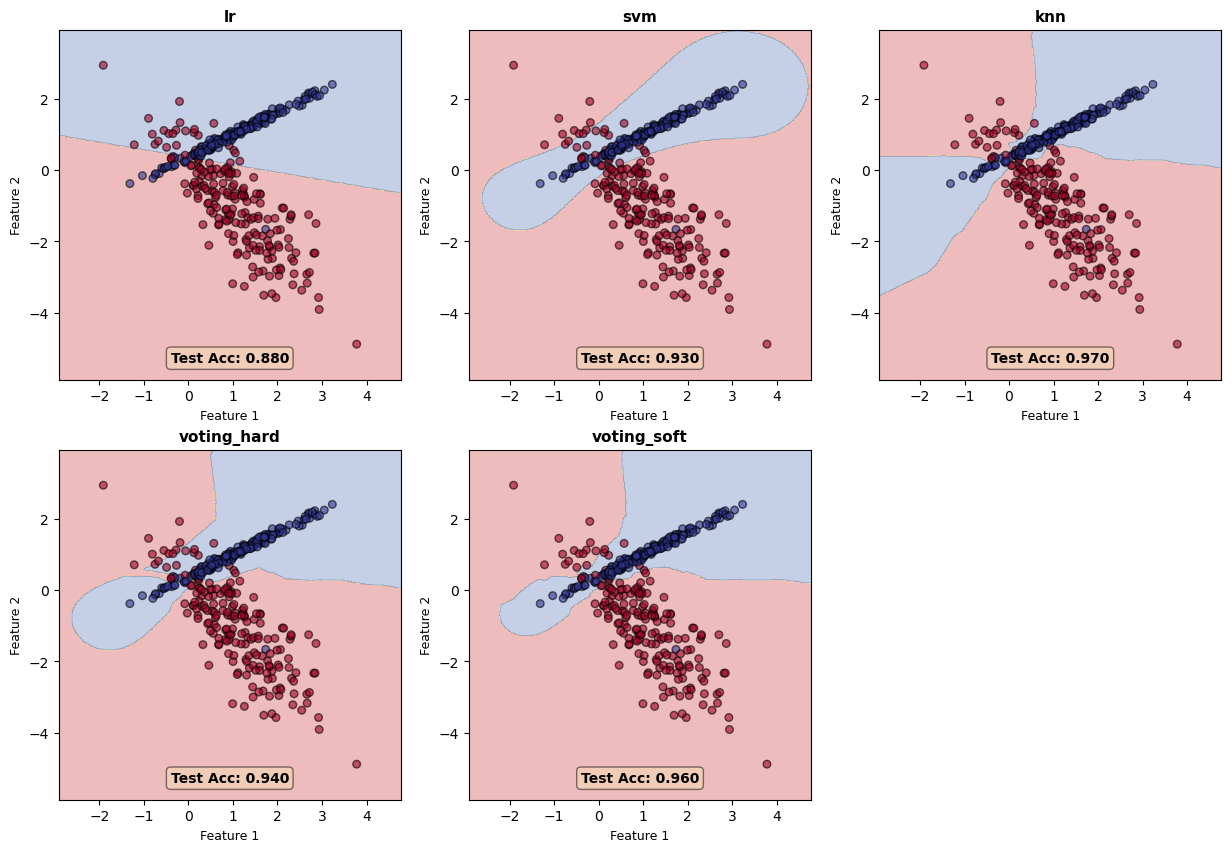

In [38]:

import matplotlib.pyplot as plt
# 결정 경계 시각화
def plot_decision_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu,
              edgecolor='black', s=30, alpha=0.6)
    ax.set_title(title, fontsize=11, weight='bold')
    ax.set_xlabel('Feature 1', fontsize=9)
    ax.set_ylabel('Feature 2', fontsize=9)

# 5개 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, (title ,model) in enumerate(models):
  row = idx // 3
  col = idx % 3
  plot_decision_boundary(model, x_train, y_train, title, axes[row, col])

  # 정확도 표시
  score = model.score(x_test, y_test)
  axes[row, col].text(0.5, 0.05, f'Test Acc: {score:.3f}',
                      transform=axes[row, col].transAxes,
                      ha='center', fontsize=10, weight='bold',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 마지막 서브플롯 제거
axes[1, 2].remove()
     

In [39]:
# 질문 어떤 종류의 모델들을 조합하면 가장 좋은 결과를 뽑을 수 잇을까
# 다양성 : 서로 다운 가장을 가진 모델 조합
# 선형모델 + 비선형 모델 + 인스턴스 기반(knn)

#### 배깅
Bootstrap Aggreating  
같은 알고리즘을 다른 데이터셋(부트스트랩 샘플)로 여러번 학습시켜 결합

(178, 13) (178,)


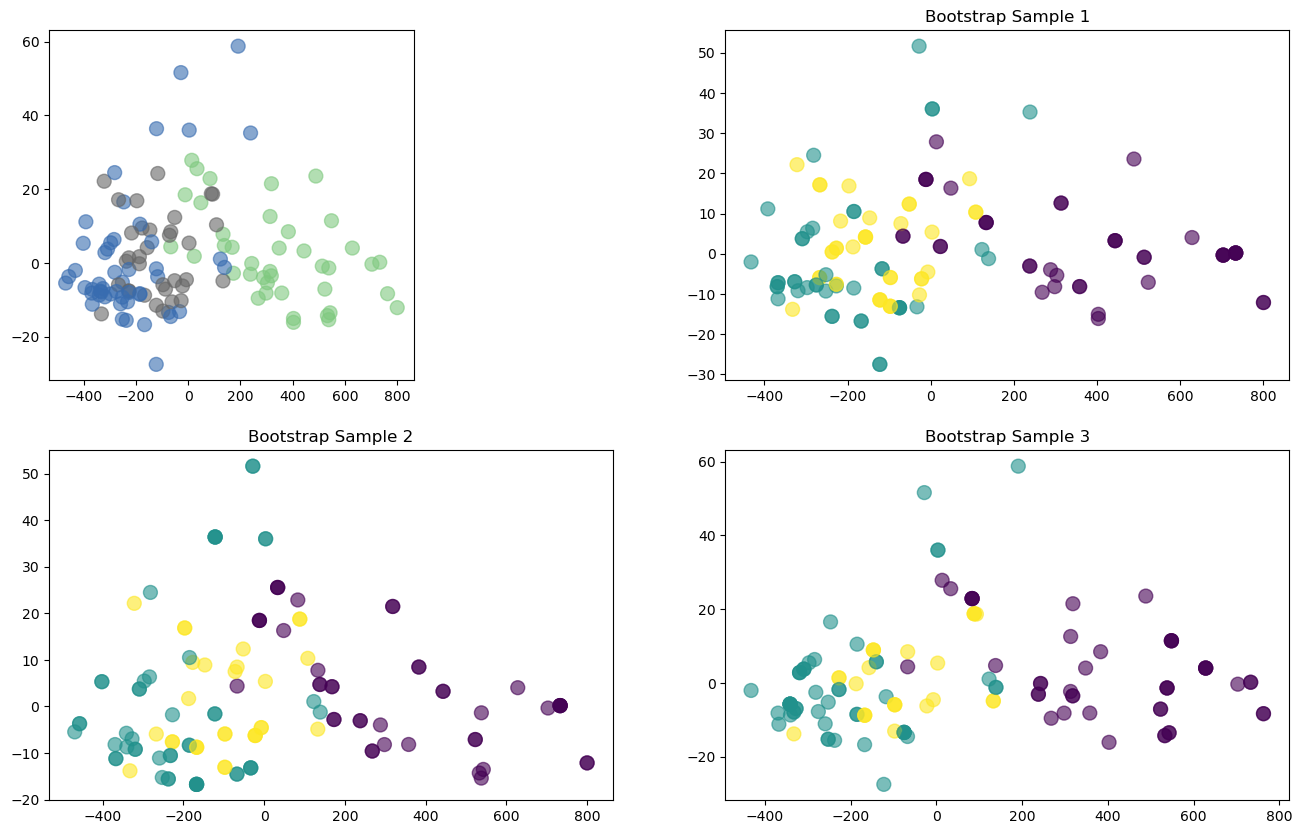

In [54]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

X,y =load_wine(return_X_y=True)
print(X.shape, y.shape)

# 차원축소 (시각화를 위해)
pca=PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.3,random_state=42 )

# 모델정의
tree = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100, random_state=42)

# 학습
tree.fit(x_train,y_train)
bagging.fit(x_train,y_train)

fig = plt.figure(figsize = (16,10))

# 1. 원본데이터
ax1 = plt.subplot(2,3,1)
ax1.scatter(x_train[:,0],x_train[:,1],c= y_train,s=100,alpha= 0.6, cmap='Accent')

# 부트스트랩 샘플3
np.random.seed(42)
for i in range(3):
  ax = plt.subplot(2,2,i+2)
  # 부트스트랩 샘플링
  n_samples = len(x_train)
  bootstrap_index = np.random.choice(n_samples, size=n_samples, replace=True)
  x_boot = x_train[bootstrap_index]
  y_boot = y_train[bootstrap_index]
  ax.scatter(x_boot[:,0], x_boot[:,1], c = y_boot,s=100,alpha = 0.6, cmap='viridis')
  ax.set_title(f'Bootstrap Sample {i+1}')
plt.show()

# ax5 = plt.subplot(2,3,5)
# plot_decision_boundary(tree,x_train,y_train, F'Decision Tree'[tree.score(x_train,y_train)], ax6)
# ax6 = plt.subplot(2,3,6)
# plot_decision_boundary(tree,x_train,y_train, F'Decision Tree'[tree.score(x_train,y_train)], ax6)
# plt.show



#### 에이다 부스트(AdaBoost)
- 약한 학습기들을 순차적으로 결합해서 강한 학습기를 만듦  
    - 이전 모델이 틀린 샘플에 더 집중  
    - 각 모델은 이전 모델의 실수를 보안  
    - 편향감소가 주요 목적  
- 배깅 vs 부스팅  
  - 학습방식:  병렬(독립적) / 순차적(의존성)  
  - 샘플:  부트스트랩 / 가중치 조정  
  - 대표: RandomForest / AdaBoost, GradientBoosting, XGBoost  
- 작동원리  
  - 모든 샘플에 동일한 가중치 부여  
  - 약한 학습기 학습  
  - 잘못 분류된 샘플의 가중치 증가  
  - 반복
  - 최종적으로 모든 학습기를 가중 투표로 결합

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        41
           1       0.94      0.94      0.94        49

    accuracy                           0.93        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.93      0.93      0.93        90

 train : 0.9523809523809523/ test 0.9333


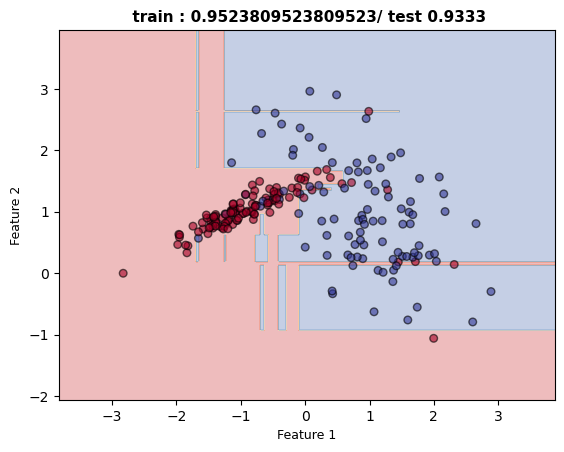

In [ ]:
import numpy as np
np.random.seed(42)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report


X,y = make_classification(n_samples= 300, n_features=2, n_redundant=0, n_informative=2, 
                    n_clusters_per_class=1, flip_y=0.1 , random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

ada = AdaBoostClassifier(
    estimator= DecisionTreeClassifier(max_depth=1),
    n_estimators= 50,
    learning_rate=1.0,
    random_state= 42
)
ada.fit(x_train,y_train)
ada.score(x_test,y_test)
print(classification_report(y_test,ada.predict(x_test)))

title = f' train : {ada.score(x_train,y_train)}/ test {ada.score(x_test,y_test):.4f}'
print(title)

# 시각화
import matplotlib.pyplot as plt
ax = plt.subplot(1,1,1)
plot_decision_boundary(ada, x_train, y_train, title, ax)


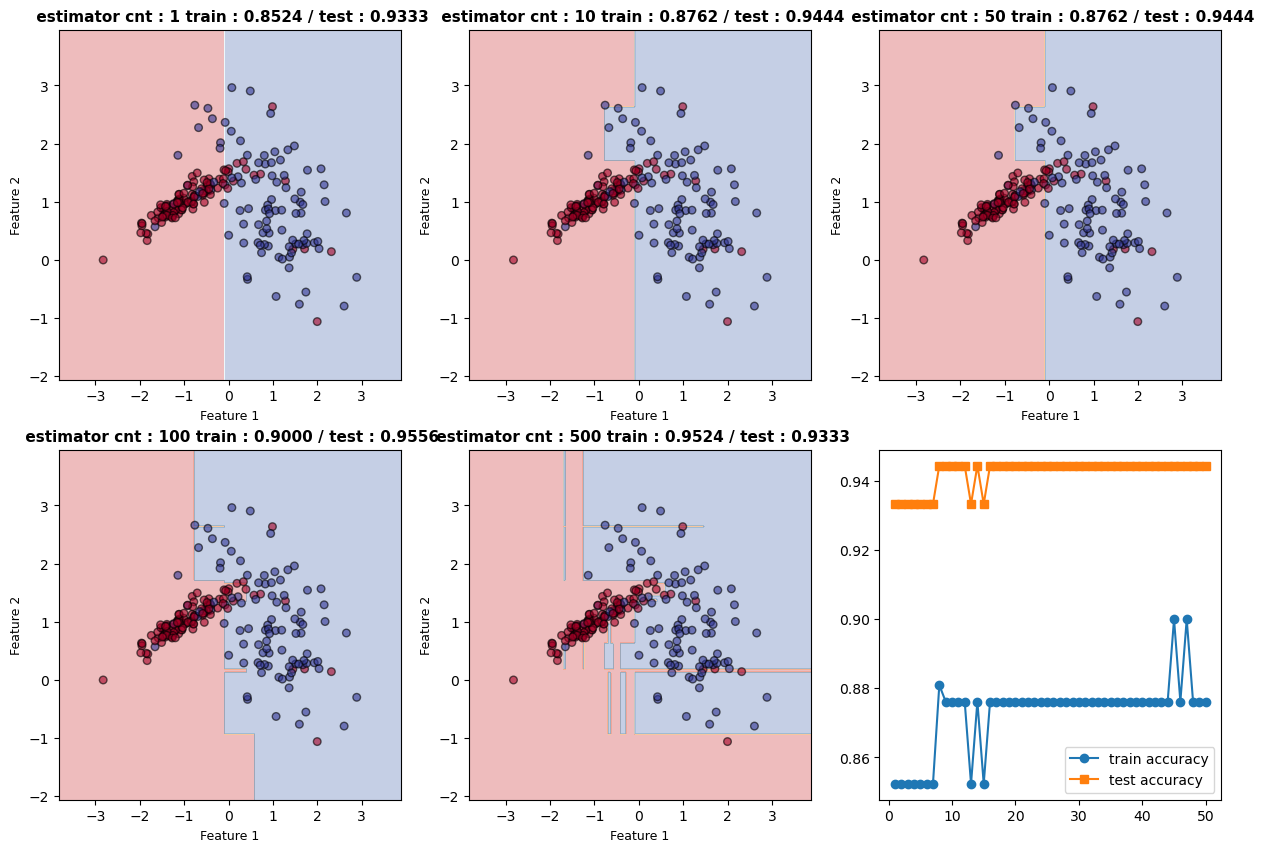

In [96]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

np.random.seed(42)
X,y = make_classification(n_samples = 300, n_features=2, n_redundant=0,n_informative=2, 
n_clusters_per_class=1, flip_y=0.1,random_state=42)

x_train,x_test,y_train,y_test =  train_test_split(X,y,test_size=0.3, random_state=42)

fig,axes = plt.subplots(2,3,figsize=(15,10))
n_estimators_lists = [1,10,50,100,500]

for idx, n_est in enumerate(n_estimators_lists):
    ada =  AdaBoostClassifier(
        estimator = DecisionTreeClassifier(max_depth=1),
        n_estimators = n_est,
        learning_rate = 1.0,
        random_state = 42
    )
    ada.fit(x_train, y_train)

    # print(classification_report(y_test, ada.predict(x_test))   )
    title = f' estimator cnt : {n_est} train : {ada.score(x_train,y_train):.4f} / test : { ada.score(x_test, y_test):.4f}' 
    # print( title  )

    # 결정경계    
    plot_decision_boundary(ada, x_train, y_train, title, axes[idx // 3 , idx % 3 ])


# 학습곡선
train_score, test_score = [],[]
n_range = range(1,51)
for n in range(1,51):
    temp = AdaBoostClassifier(
    estimator = DecisionTreeClassifier(max_depth=1),
    n_estimators = n,
    learning_rate = 1.0,
    random_state = 42
    )
    temp.fit(x_train, y_train)
    train_score.append(temp.score(x_train, y_train))
    test_score.append(temp.score(x_test, y_test))
axes[1,2].plot(range(1,51),train_score,label = 'train accuracy', marker='o')
axes[1,2].plot(range(1,51),test_score,label = 'test accuracy', marker='s')
axes[1,2].legend()

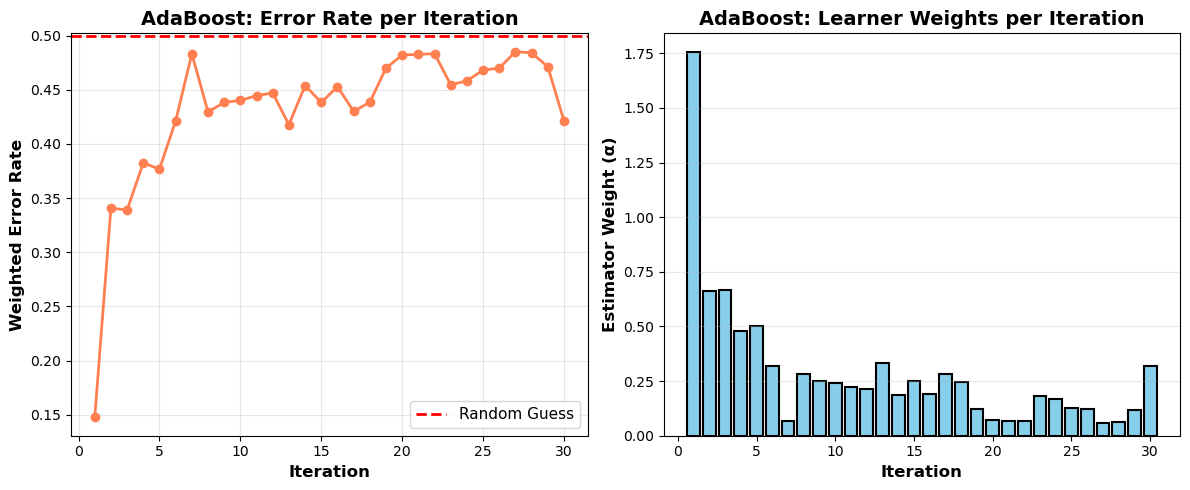

ADABOOST ANALYSIS
Number of Estimators: 500
Training Accuracy: 0.9524
Test Accuracy: 0.9333

First 10 Estimator Errors:
  Round  1: 0.1476
  Round  2: 0.3407
  Round  3: 0.3391
  Round  4: 0.3825
  Round  5: 0.3768
  Round  6: 0.4213
  Round  7: 0.4831
  Round  8: 0.4296
  Round  9: 0.4383
  Round 10: 0.4401

Last 10 Estimator Errors:
  Round  1: 0.4721
  Round  2: 0.4926
  Round  3: 0.4807
  Round  4: 0.4814
  Round  5: 0.4709
  Round  6: 0.4725
  Round  7: 0.4820
  Round  8: 0.4877
  Round  9: 0.4822
  Round 10: 0.4723

Last 10 Estimator Weights:
  Round  1: 0.1117
  Round  2: 0.0296
  Round  3: 0.0772
  Round  4: 0.0744
  Round  5: 0.1165
  Round  6: 0.1101
  Round  7: 0.0722
  Round  8: 0.0493
  Round  9: 0.0711
  Round 10: 0.1108


In [97]:
# 오차 감소 시각화
plt.figure(figsize=(12, 5))

# 왼쪽: 단계별 오차율
plt.subplot(1, 2, 1)
estimator_errors = ada.estimator_errors_[:30]  # 처음 30개만
plt.plot(range(1, len(estimator_errors) + 1), estimator_errors, 
         marker='o', linewidth=2, markersize=6, color='coral')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess', linewidth=2)
plt.xlabel('Iteration', fontsize=12, weight='bold')
plt.ylabel('Weighted Error Rate', fontsize=12, weight='bold')
plt.title('AdaBoost: Error Rate per Iteration', fontsize=14, weight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 오른쪽: 학습기 가중치
plt.subplot(1, 2, 2)
estimator_weights = ada.estimator_weights_[:30]
plt.bar(range(1, len(estimator_weights) + 1), estimator_weights, 
        color='skyblue', edgecolor='black', linewidth=1.5)
plt.xlabel('Iteration', fontsize=12, weight='bold')
plt.ylabel('Estimator Weight (α)', fontsize=12, weight='bold')
plt.title('AdaBoost: Learner Weights per Iteration', fontsize=14, weight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('adaboost_errors_weights.png', dpi=150, bbox_inches='tight')
plt.show()

print("=" * 70)
print("ADABOOST ANALYSIS")
print("=" * 70)
print(f"Number of Estimators: {ada.n_estimators}")
print(f"Training Accuracy: {ada.score(x_train, y_train):.4f}")
print(f"Test Accuracy: {ada.score(x_test, y_test):.4f}")
print(f"\nFirst 10 Estimator Errors:")
for i, error in enumerate(ada.estimator_errors_[:10], 1):
    print(f"  Round {i:2d}: {error:.4f}")

print(f"\nLast 10 Estimator Errors:")
for i, error in enumerate(ada.estimator_errors_[-10:], 1):
    print(f"  Round {i:2d}: {error:.4f}")


print(f"\nLast 10 Estimator Weights:")
for i, weight in enumerate(ada.estimator_weights_[-10:], 1):
    print(f"  Round {i:2d}: {weight:.4f}")
print("=" * 70)